In [ ]:
#pip install pandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 3.2 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-

In [ ]:
#pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 KB 8.2 MB/s eta 0:00:00


In [ ]:
#pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=1f246add0d4d9f315ad27ed6c4d9538b23a8a5b3f98d52d361d242bdeb78b0da
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [ ]:
import pandas as pd # tool for data processing
from pandas_datareader import data # tool for data processing
import plotly.graph_objects as go # tool for data visualization
import yfinance as yf # tool for downloading histrocial market data from "Yahoo! Finance"
from datetime import date # tool for manipulating dates and times
from dateutil.relativedelta import relativedelta # tool for manipulating dates and times
import numpy as np # tool for handling vectors, matrices or large multidimensional arrays
from sklearn.linear_model import LinearRegression # tool for machine leraning (Linear Model)
from sklearn.model_selection import train_test_split # tool for machine learning
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

# predefined start date, later it will be changed by the user
sdate = '2019-01-01'
# predefined end date, later it will be changed by the user
edate = '2019-01-02'

#Using while-True to prevent wrong user inputs:

while True:
    try:
        # The user needs to input a prefered stock symbol; this symbol will be saved in the variable "symbol"
        #symbol = input('Please enter a stock symbol: ')
        selected_stocks = []
        while not selected_stocks:
          selected_stocks = input("Please enter the ticker symbols (comma-separated) for the stocks you want to include in your portfolio:\n").upper().split(',')
          selected_stocks = [s.strip() for s in selected_stocks]
        # The data from yahoo! finance will be saved in the variable "df"
        # With the command from the "pandas-datareader" library we get the data
        # Within the command, we define at first the stocksymbol, then define the data source which is "yahoo" for Yahoo!Finance, and then define a start- and enddate
        #df = pdr.get_data_yahoo(symbol, sdate, edate)
        #df = pdr.get_data_yahoo(selected_stocks, sdate, edate)
        stock_data = yf.download(selected_stocks, start=sdate, end=edate)['Adj Close']
        break
    # If some errors occur (e.g. invalid stock symbol), the user gets an information that the input is invalid and must enter something else 
    except(KeyError, OSError):
        print(color.BOLD + color.UNDERLINE + f'> {selected_stocks} is not a valid stock symbol. Please try again...' + color.END) 




# Make a User Menu
print(color.BOLD + color.UNDERLINE + '\n> Have a look at the different options on analyzing the stock data:' + color.END)
choice = True
while choice:
    print(f'''\nWhat would you like to do: 
    A - Show me the price chart of my chosen stocks
    B - Show me analysis on my portfolio's return
    C - Show me the revenue and earnings of my chosen stock
    D - Show me the cash flow statement of my chosen stock
    E - Show me the analyst recommendations for the stock of the last 6 months
    F - Show me the price prediction for the next 30 days
    Q - Quit the program
    ''')
    choice = (input('''\nPlease enter your choice (e.g. for the first option type "A"): '''))

    # Setting an condition for the first option; if condition is False, it checks the next elif functions until it meets an condition that is True or ends at "else"  
    
    
    # OPTION 1: Show me the price chart of my chosen stock
    if choice == 'A' or choice == 'a':
        # Now the user can enter his prefered daterange (sdate = startdate; edate = enddate)
        sdate = input('Please enter the start date (YYYY-MM-DD) for your portfolio:\n')
        edate = input('Please enter the end date (YYYY-MM-DD) for your portfolio:\n ')
    
        # We again are using the same formula as in our while True function above, because the user changed the start- and enddate
        # variable and therefore we have to redefine the variable df for plotting the user desired daterange
        #df = pdr.get_data_yahoo(selected_stocks, sdate, edate)
        stock_data = yf.download(selected_stocks, start=sdate, end=edate)['Adj Close']
        # If we look at the DataFrame "df", we see that there are 6 variables/columns: "High", "Low", "Open", "Close", "Volume" and "Adj Close"
        # We also see that the Index of the "df" is the date (DatetimeIndex)
        # For the Plotting we want to use for the x-axis the date and for the y-axis the Adjusted Close values
        # However, this is only possible if both axes are assigned by variables; this is not the case with the date, because it is the index 
        # Therefore we replace the index with simple sequential numbers and save the old index ("DatetimeIndex") as a variable
        #df = df.reset_index()
        # Now the DataFrame "df" has 7 variables/columns: "Date", High", "Low", "Open", "Close", "Volume" and "Adj Close"

        # Plotting the chart
        import plotly.graph_objs as go

              # Create traces for each stock
        traces = []
        for stock in stock_data.columns:
            traces.append(go.Scatter(
                x=stock_data.index,
                y=stock_data[stock],
                mode='lines',
                name=stock
              ))  

        # Create the layout for the plot
        layout = go.Layout(
            title=f'Stock Prices from {sdate} to {edate}',
                xaxis=dict(title='Date'),
                yaxis=dict(title='Adjusted Closing Price in USD'),
                xaxis_tickfont_size=14,
                yaxis_tickfont_size=14
                )

        # Create the figure and add the traces and layout
        fig = go.Figure(data=traces, layout=layout)

        # Display the plot
        fig.show()
        break

    # OPTION 2: Show me analysis on my portfolio's return
    if choice == 'B' or choice == 'b':
      # Lets see some basic statistics on our selected stocks. 
      # First lets see the return of the closing prices
      returns = stock_data.pct_change()
      #returns.dropna(inplace=True)
      returns.head()



      # Correlation can help us determine how closely the return of each stocks' return values are related.

      import plotly.express as px

      corr_mat = returns.corr()

      fig = px.imshow(corr_mat,
                      labels=dict(x="Stocks", y="Stocks", color="Correlation"),
                      x=corr_mat.columns,
                      y=corr_mat.columns,
                      color_continuous_scale=px.colors.sequential.RdBu,
                      zmin=-1,
                      zmax=1)

      fig.update_layout(title="Correlation between Return values of the selected Stocks:",
                        xaxis=dict(title="", showticklabels=True),
                        yaxis=dict(title="", showticklabels=True),
                        margin=dict(l=40, r=40, t=60, b=10),
                        height=600,
                        width=800)

      fig.show()

      #Let's plot the returns of this stock
      #import plotly.graph_objs as go

      # Create traces for each stock
      traces = []
      for stock in returns.columns:
            traces.append(go.Scatter(
                x=returns.index,
                y=returns[stock],
                mode='lines',
                name=stock
            ))  

      # Create the layout for the plot
      layout = go.Layout(
          title=f'Stocks Return Values from {sdate} to {edate}',
          xaxis=dict(title='Date'),
          yaxis=dict(title='Stock return in USD'),
          xaxis_tickfont_size=14,
          yaxis_tickfont_size=14
        )

      # Create the figure and add the traces and layout
      fig = go.Figure(data=traces, layout=layout)

      # Display the plot
      fig.show()

      #we can also plot individually
      for i, stock in enumerate(returns.columns, start=1):
          sns.set
          plt.figure(figsize=(20, 20))
          plt.subplot(len(returns.columns), 1, i)
          plt.plot(returns[stock])
          plt.title(f"{stock}")
          plt.tight_layout()
          plt.show()

      #Now let's see the portfolio return till this date

      #import plotly.graph_objects as go

      # Calculate the total portfolio return
      portfolio_return = returns.sum(axis=1)

      # Create a Plotly figure
      fig = go.Figure()

      # Add a line trace for the portfolio return
      fig.add_trace(go.Scatter(x=portfolio_return.index, y=portfolio_return.values, name='Portfolio Return'))

      # Set the title and axis labels
      fig.update_layout(title=f'Portfolio Return from {sdate} to {edate}', xaxis_title='Date', yaxis_title='Returns')

      # Show the plot
      fig.show()

      # Now let's calculate the volatility of the returns of our portfolio
      # Here we are using a rolling() function to determine the standard deviation of returns as the data is time series
      # the optimal window for rolling std is 20-30 trading days
      #import plotly.graph_objs as go

      # Calculate rolling volatility of each stock
      volatility = returns.rolling(window=30).std()

      # Plot the volatility of each stock using Plotly
      fig = go.Figure()
      for stock in volatility.columns:
          fig.add_trace(go.Scatter(x=volatility.index, y=volatility[stock], mode='lines', name=stock))

      fig.update_layout(title="Volatility of Each Stock's Return",
                        xaxis_title='Date',
                        yaxis_title='Volatility')

      fig.show()

      avg_volatility = volatility.mean()

      print('The avg volatility of each stock over the selected date range is:\n',avg_volatility)
      print(f'\n\nHighest Volatility in the Portfolio:',avg_volatility.idxmax(),',',round(avg_volatility.max(),3))
      print(f'\nLowest Volatility in the Portfolio:',avg_volatility.idxmin(),',',round(avg_volatility.min(),3))

      #Let's plot the risk return trade off chart to see how the stock's performance
      import plotly.graph_objs as go

      # Calculate mean return and volatility
      mean_return = returns.mean()
      volatility = returns.std()

      # Create a scatter plot trace
      trace = go.Scatter(
          x=volatility,
          y=mean_return,
          mode='markers',
          marker=dict(
              size=15,
              color='blue',
              symbol='circle',
              line=dict(
                  width=2
              )
          ),
          text=returns.columns.tolist(),
      )

      # Set the layout for the plot
      layout = go.Layout(
          title='Risk-Return Tradeoff',
          xaxis=dict(title='Volatility'),
          yaxis=dict(title='Mean Return'),
      )

      # Combine the trace and layout and plot the figure
      fig = go.Figure(data=[trace], layout=layout)
      fig.show()
      break

Please enter the ticker symbols (comma-separated) for the stocks you want to include in your portfolio:
TSLA,GOOG,msft
[*********************100%***********************]  3 of 3 completed

3 Failed downloads:
- GOOG: No data found for this date range, symbol may be delisted
- TSLA: No data found for this date range, symbol may be delisted
- MSFT: No data found for this date range, symbol may be delisted

> Have a look at the different options on analyzing the stock data:

What would you like to do: 
    A - Show me the price chart of my chosen stocks
    B - Show me a price comparison with an additional stock
    C - Show me the revenue and earnings of my chosen stock
    D - Show me the cash flow statement of my chosen stock
    E - Show me the analyst recommendations for the stock of the last 6 months
    F - Show me the price prediction for the next 30 days
    Q - Quit the program
    

Please enter your choice (e.g. for the first option type "A"): a
Please enter the start date (YY

In [ ]:
# Lets see some basic statistics on our selected stocks. 
# First lets see the return of the closing prices
returns = stock_data.pct_change()
#returns.dropna(inplace=True)
returns.head()

,AMZN,JPM,META,TSLA
Date,,,,
2016-01-04,NaN,NaN,NaN,NaN
2016-01-05,-0.005024,0.001729,0.004989,0.000090
2016-01-06,-0.001799,-0.014436,0.002336,-0.019648
2016-01-07,-0.039058,-0.040439,-0.049043,-0.015477
2016-01-08,-0.001464,-0.022399,-0.006025,-0.021563


We get nan values for here as some of the stocks were introduced in the market after the selected start date. So there will be nan values for those dates before the stocks first date in the market. 

In this case, we cannot simply neglect the nan values. How should we handle this? 

In [ ]:
# Correlation can help us determine how closely the return of each stocks' return values are related.

import plotly.express as px

corr_mat = returns.corr()

fig = px.imshow(corr_mat,
                labels=dict(x="Stocks", y="Stocks", color="Correlation"),
                x=corr_mat.columns,
                y=corr_mat.columns,
                color_continuous_scale=px.colors.sequential.RdBu,
                zmin=-1,
                zmax=1)

fig.update_layout(title="Correlation between Return values of the selected Stocks:",
                  xaxis=dict(title="", showticklabels=True),
                  yaxis=dict(title="", showticklabels=True),
                  margin=dict(l=40, r=40, t=60, b=10),
                  height=600,
                  width=800)

fig.show()


In [ ]:
#Let's plot the returns of this stock
import plotly.graph_objs as go

# Create traces for each stock
traces = []
for stock in returns.columns:
      traces.append(go.Scatter(
          x=returns.index,
          y=returns[stock],
          mode='lines',
          name=stock
      ))  

# Create the layout for the plot
layout = go.Layout(
    title=f'Stocks Return Values from {sdate} to {edate}',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock return in USD'),
    xaxis_tickfont_size=14,
    yaxis_tickfont_size=14
  )

# Create the figure and add the traces and layout
fig = go.Figure(data=traces, layout=layout)

# Display the plot
fig.show()

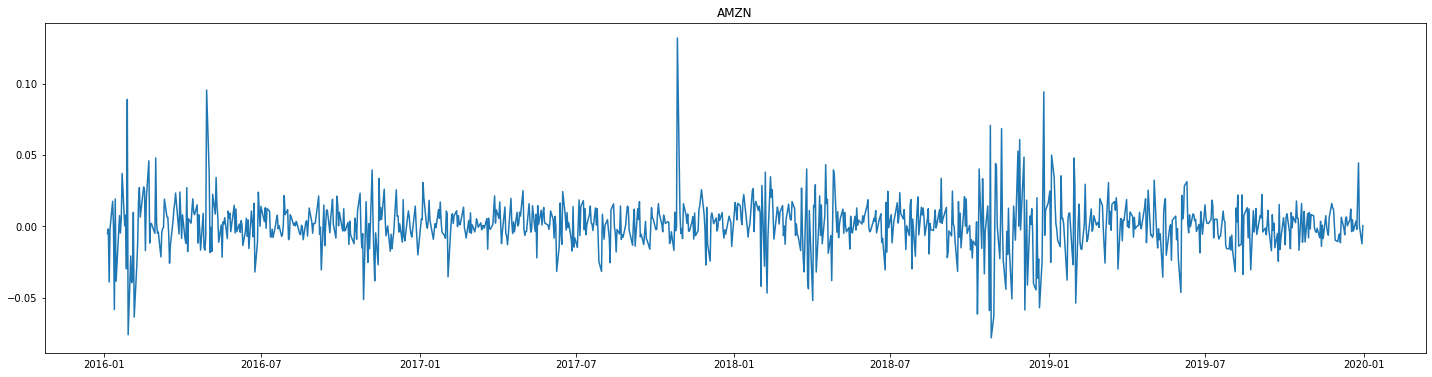

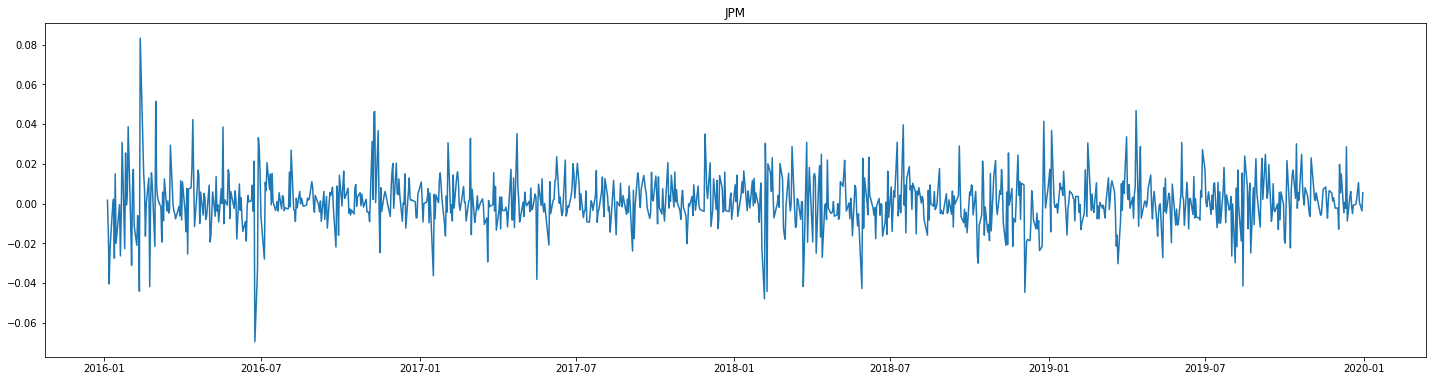

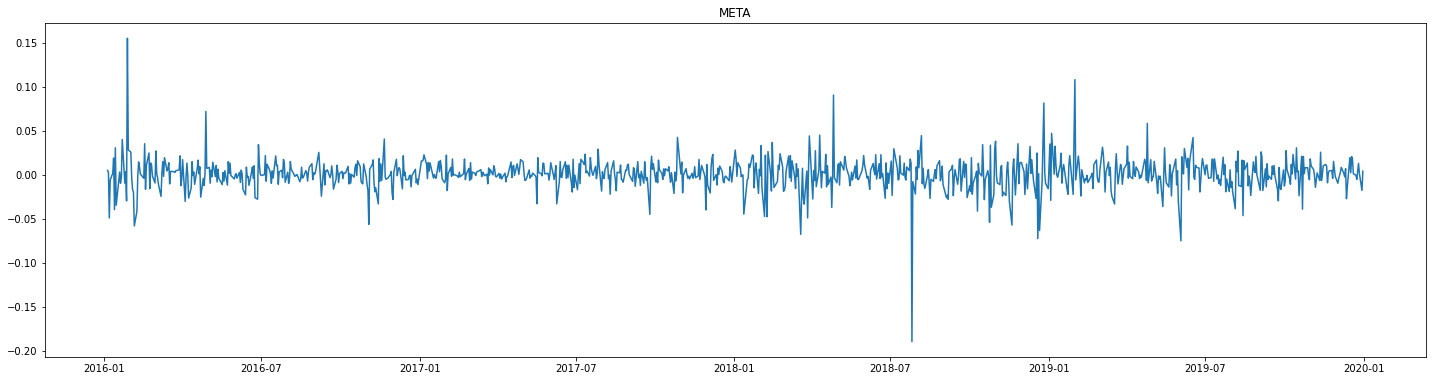

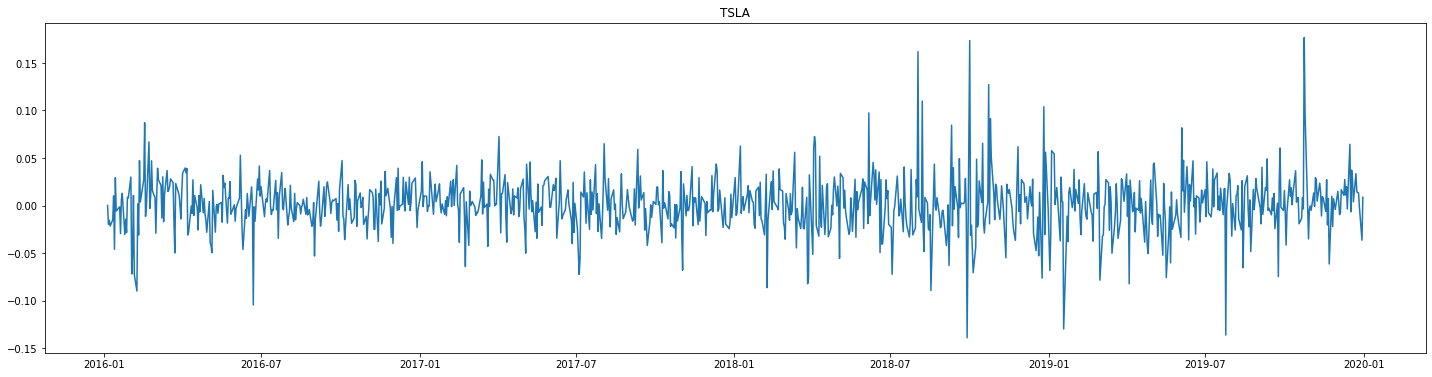

In [ ]:
#we can also plot individually
for i, stock in enumerate(returns.columns, start=1):
    sns.set
    plt.figure(figsize=(20, 20))
    plt.subplot(len(returns.columns), 1, i)
    plt.plot(returns[stock])
    plt.title(f"{stock}")
    plt.tight_layout()
    plt.show()

In [ ]:
#Now let's see the portfolio return till this date

import plotly.graph_objects as go

# Calculate the total portfolio return
portfolio_return = returns.sum(axis=1)

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for the portfolio return
fig.add_trace(go.Scatter(x=portfolio_return.index, y=portfolio_return.values, name='Portfolio Return'))

# Set the title and axis labels
fig.update_layout(title=f'Portfolio Return from {sdate} to {edate}', xaxis_title='Date', yaxis_title='Returns')

# Show the plot
fig.show()

In [ ]:
# Now let's calculate the volatility of the returns of our portfolio
# Here we are using a rolling() function to determine the standard deviation of returns as the data is time series
# the optimal window for rolling std is 20-30 trading days
import plotly.graph_objs as go

# Calculate rolling volatility of each stock
volatility = returns.rolling(window=30).std()

# Plot the volatility of each stock using Plotly
fig = go.Figure()
for stock in volatility.columns:
    fig.add_trace(go.Scatter(x=volatility.index, y=volatility[stock], mode='lines', name=stock))

fig.update_layout(title="Volatility of Each Stock's Return",
                  xaxis_title='Date',
                  yaxis_title='Volatility')

fig.show()

avg_volatility = volatility.mean()

print('The avg volatility of each stock over the selected date range is:\n',avg_volatility)
print(f'\n\nHighest Volatility in the Portfolio:',avg_volatility.idxmax(),',',round(avg_volatility.max(),3))
print(f'\nLowest Volatility in the Portfolio:',avg_volatility.idxmin(),',',round(avg_volatility.min(),3))

The avg volatility of each stock over the selected date range is:
 AMZN    0.015688
JPM     0.012355
META    0.016319
TSLA    0.027848
dtype: float64


Highest Volatility in the Portfolio: TSLA , 0.028

Lowest Volatility in the Portfolio: JPM , 0.012


In [ ]:
import plotly.graph_objs as go

# Calculate mean return and volatility
mean_return = returns.mean()
volatility = returns.std()

# Create a scatter plot trace
trace = go.Scatter(
    x=volatility,
    y=mean_return,
    mode='markers',
    marker=dict(
        size=15,
        color='blue',
        symbol='circle',
        line=dict(
            width=2
        )
    ),
    text=returns.columns.tolist(),
)

# Set the layout for the plot
layout = go.Layout(
    title='Risk-Return Tradeoff',
    xaxis=dict(title='Volatility'),
    yaxis=dict(title='Mean Return'),
)

# Combine the trace and layout and plot the figure
fig = go.Figure(data=[trace], layout=layout)
fig.show()